In [ ]:
# Standard libraries
import os
import sys
import zipfile
import glob

# Image processing
from PIL import Image  # Image handling

# PyTorch and deep learning utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization and progress tracking
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Copy the project folder from Google Drive to local storage for faster access in Colab
!cp -r "/content/drive/MyDrive/COLAB/PROJECTs/FaceGeneration/HUMAN/LDM1" /content/

# Add project directories to the Python path to allow module imports
sys.path.append('/content/LDM1')
sys.path.append('/content/LDM1/vae')

# Import project-specific configurations and models
from config import cfg  # Configuration settings
from model_vae import VAE, Encoder, Decoder
from evaluate_vae import (  # Evaluation functions for the VAE model
    visualize_random_input_output,  # Function to visualize input-output pairs
    track_tensor_values,  # Track tensor changes during training
    plot_losses,  # Plot training and validation losses
    calculate_metrics  # Compute evaluation metrics
)


In [3]:
# Download FFHQ dataset from Kaggle
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

Dataset URL: https://www.kaggle.com/datasets/arnaud58/flickrfaceshq-dataset-ffhq
License(s): CC-BY-SA-3.0
100% 19.5G/19.5G [15:29<00:00, 21.6MB/s]
100% 19.5G/19.5G [15:29<00:00, 22.5MB/s]


In [4]:
dataset_zip = "flickrfaceshq-dataset-ffhq.zip"

# Extract the dataset zip file into the specified directory
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("./ffhq_dataset")

# Define the path to the extracted dataset
data_dir = './ffhq_dataset'


In [5]:
# Define image transformations: resizing, tensor conversion, and normalization
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.42, 0.44, 0.41], std=[0.42, 0.43, 0.40])
])

In [6]:
# Custom dataset class for loading FFHQ images
class FFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Collect all PNG and JPG file paths in the dataset directory
        self.file_paths = glob.glob(f"{root_dir}/*.png") + glob.glob(f"{root_dir}/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load image and convert to RGB
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        return image

# Load the dataset with transformations
dataset = FFHQDataset(root_dir=data_dir, transform=transform)

# Limit dataset size based on configuration (cfg.subset_size)
limited_dataset, _ = random_split(dataset, [cfg.subset_size, len(dataset) - cfg.subset_size])

# Split dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * cfg.subset_size)
test_size = cfg.subset_size - train_size
train_dataset, test_dataset = random_split(limited_dataset, [train_size, test_size])


In [7]:
# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

In [8]:
# KL divergence loss for VAE
def kl_divergence_loss(mean, log_variance, kl_weight=cfg.kl_weight, min_kl_loss=cfg.min_kl_loss):
    kl_loss_raw = -0.5 * torch.mean(1 + log_variance - mean.pow(2) - log_variance.exp())
    kl_loss_raw = torch.clamp(kl_loss_raw, min=min_kl_loss)  # Prevent vanishing loss
    return kl_weight * kl_loss_raw

# Reconstruction loss (MSE)
def reconstruction_loss(reconstructed, original):
    return nn.MSELoss()(reconstructed, original)

In [9]:
class EarlyStopping:
    def __init__(self, patience=cfg.early_stopping_patience, min_delta=0,
                 checkpoints_path="/content/drive/MyDrive/COLAB/PROJECTs/FaceGeneration/HUMAN/LDM1/checkpoints"):
        # Initialize early stopping parameters
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.checkpoints_path = checkpoints_path

    def check(self, validation_loss, model):
        # Save model if validation loss improves
        if self.best_loss is None or validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0

            # Save model components separately
            encoder_path = os.path.join(self.checkpoints_path, "best_encoder.pth")
            decoder_path = os.path.join(self.checkpoints_path, "best_decoder.pth")
            vae_path = os.path.join(self.checkpoints_path, "best_vae.pth")

            torch.save(model.encoder.state_dict(), encoder_path)
            torch.save(model.decoder.state_dict(), decoder_path)
            torch.save(model.state_dict(), vae_path)

            print(f"Model saved with validation loss: {validation_loss:.4f}\n")
        else:
            self.counter += 1  # Increase counter if no improvement

        # Stops when there is no improvement in validation loss
        if self.counter >= self.patience:
            print("Early Stopping triggered. Training stopped.")
            return True

        return False


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Training
def train_vae(model, optimizer,
              train_loader=train_loader,
              test_loader=test_loader,
              device=device,
              num_epochs=cfg.epochs,
              kl_weight=cfg.kl_weight,
              min_kl_loss=cfg.min_kl_loss,
              kl_annealing_epochs=(cfg.epochs//2)-1,
              start_early_stopping=(3 * cfg.epochs) // 5):

    model.to(device)
    model.train()

    # Loss tracking dictionary
    all_losses = {
        'total': [], 'kl': [], 'recon': [],
        'train': [], 'val': [], 'val_kl': [], 'val_recon': []
    }

    best_val_loss = float('inf')

    # Scheduler & Early Stopping
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=cfg.scheduler_factor, patience=cfg.scheduler_patience)
    early_stopping = EarlyStopping()

    for ep in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # KL annealing (gradual weight increase)
        kl_weight = min(min_kl_loss + (ep / (kl_annealing_epochs - 1)) * (1.0 - min_kl_loss), 1.0)

        with tqdm(train_loader, desc=f"Epoch {ep + 1}/{num_epochs}") as progress_bar:
            for batch_idx, data in enumerate(progress_bar):
                inputs = data.to(device)

                # Forward pass
                mean, log_variance, reconstructed = model(inputs)

                # Compute losses
                kl_loss = kl_divergence_loss(mean, log_variance, kl_weight)
                recon_loss = reconstruction_loss(reconstructed, inputs)
                loss = recon_loss + kl_loss

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                epoch_loss += loss.item()

                # Store batch losses
                all_losses['total'].append(loss.item())
                all_losses['kl'].append(kl_loss.item())
                all_losses['recon'].append(recon_loss.item())

                # Update progress bar
                progress_bar.set_postfix({
                    "Step Loss": f"{loss.item():.4f}",
                    "KL Loss": f"{kl_loss.item():.4f}",
                    "Reconstruction Loss": f"{recon_loss.item():.4f}",
                    "KL Weight": f"{kl_weight:.2f}"
                })

        # Average training loss
        epoch_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_kl, val_recon = 0.0, 0.0

        with torch.no_grad():
            for val_data in test_loader:
                val_inputs = val_data.to(device)
                val_mean, val_log_variance, val_reconstructed = model(val_inputs)
                val_kl_loss = kl_divergence_loss(val_mean, val_log_variance, kl_weight)
                val_recon_loss = reconstruction_loss(val_reconstructed, val_inputs)

                val_kl += val_kl_loss.item()
                val_recon += val_recon_loss.item()

        val_kl /= len(test_loader)
        val_recon /= len(test_loader)
        val_loss = val_kl + val_recon

        # Store epoch losses
        all_losses['train'].append(epoch_loss)
        all_losses['val'].append(val_loss)
        all_losses['val_kl'].append(val_kl)
        all_losses['val_recon'].append(val_recon)

        print(f"Epoch {ep + 1} | Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}\n")

        # Learning rate adjustment & early stopping
        if ep >= start_early_stopping:
            old_lrs = [group['lr'] for group in optimizer.param_groups]
            scheduler.step(val_loss)
            new_lrs = [group['lr'] for group in optimizer.param_groups]

            for i, (old_lr, new_lr) in enumerate(zip(old_lrs, new_lrs)):
                if old_lr != new_lr:
                    print(f"LR updated for group {i}: {old_lr:.6f} -> {new_lr:.6f}")

            if early_stopping.check(val_loss, model):
                print("Early stopping triggered.")
                break

    return all_losses


In [12]:
# Initialize VAE model with config parameters
vae = VAE(in_channels=cfg.in_channels, latent_channels=cfg.latent_channels, out_channels=cfg.out_channels)

# Optimizer setup with config learning rate
optimizer = optim.Adam(vae.parameters(), lr=cfg.optimizer_lr)

In [13]:
# Train the model
all_losses = train_vae(vae, optimizer, train_loader, test_loader, device)

Epoch 1/30: 100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s, Step Loss=0.1872, KL Loss=0.0064, Reconstruction Loss=0.1808, KL Weight=0.08]


Epoch 1 | Train Loss: 0.1304, Validation Loss: 0.1181



Epoch 2/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1071, KL Loss=0.0121, Reconstruction Loss=0.0951, KL Weight=0.15]


Epoch 2 | Train Loss: 0.1172, Validation Loss: 0.1133



Epoch 3/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.0912, KL Loss=0.0177, Reconstruction Loss=0.0735, KL Weight=0.22]


Epoch 3 | Train Loss: 0.1149, Validation Loss: 0.1128



Epoch 4/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s, Step Loss=0.1352, KL Loss=0.0234, Reconstruction Loss=0.1119, KL Weight=0.29]


Epoch 4 | Train Loss: 0.1156, Validation Loss: 0.1142



Epoch 5/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.0909, KL Loss=0.0290, Reconstruction Loss=0.0619, KL Weight=0.36]


Epoch 5 | Train Loss: 0.1178, Validation Loss: 0.1169



Epoch 6/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.77it/s, Step Loss=0.1010, KL Loss=0.0347, Reconstruction Loss=0.0663, KL Weight=0.43]


Epoch 6 | Train Loss: 0.1209, Validation Loss: 0.1203



Epoch 7/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.1057, KL Loss=0.0404, Reconstruction Loss=0.0654, KL Weight=0.50]


Epoch 7 | Train Loss: 0.1248, Validation Loss: 0.1246



Epoch 8/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1134, KL Loss=0.0460, Reconstruction Loss=0.0674, KL Weight=0.58]


Epoch 8 | Train Loss: 0.1290, Validation Loss: 0.1291



Epoch 9/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1540, KL Loss=0.0517, Reconstruction Loss=0.1023, KL Weight=0.65]


Epoch 9 | Train Loss: 0.1335, Validation Loss: 0.1334



Epoch 10/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1107, KL Loss=0.0574, Reconstruction Loss=0.0533, KL Weight=0.72]


Epoch 10 | Train Loss: 0.1383, Validation Loss: 0.1384



Epoch 11/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1340, KL Loss=0.0630, Reconstruction Loss=0.0710, KL Weight=0.79]


Epoch 11 | Train Loss: 0.1432, Validation Loss: 0.1434



Epoch 12/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1811, KL Loss=0.0687, Reconstruction Loss=0.1125, KL Weight=0.86]


Epoch 12 | Train Loss: 0.1483, Validation Loss: 0.1484



Epoch 13/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.1663, KL Loss=0.0743, Reconstruction Loss=0.0919, KL Weight=0.93]


Epoch 13 | Train Loss: 0.1535, Validation Loss: 0.1536



Epoch 14/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.1408, KL Loss=0.0800, Reconstruction Loss=0.0608, KL Weight=1.00]


Epoch 14 | Train Loss: 0.1588, Validation Loss: 0.1590



Epoch 15/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.1646, KL Loss=0.0800, Reconstruction Loss=0.0846, KL Weight=1.00]


Epoch 15 | Train Loss: 0.1585, Validation Loss: 0.1587



Epoch 16/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1429, KL Loss=0.0800, Reconstruction Loss=0.0629, KL Weight=1.00]


Epoch 16 | Train Loss: 0.1582, Validation Loss: 0.1584



Epoch 17/30: 100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s, Step Loss=0.1480, KL Loss=0.0800, Reconstruction Loss=0.0680, KL Weight=1.00]


Epoch 17 | Train Loss: 0.1579, Validation Loss: 0.1584



Epoch 18/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1454, KL Loss=0.0800, Reconstruction Loss=0.0654, KL Weight=1.00]


Epoch 18 | Train Loss: 0.1578, Validation Loss: 0.1581



Epoch 19/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1587, KL Loss=0.0800, Reconstruction Loss=0.0787, KL Weight=1.00]


Epoch 19 | Train Loss: 0.1575, Validation Loss: 0.1579

Model saved with validation loss: 0.1579



Epoch 20/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.2038, KL Loss=0.0800, Reconstruction Loss=0.1238, KL Weight=1.00]


Epoch 20 | Train Loss: 0.1574, Validation Loss: 0.1577

Model saved with validation loss: 0.1577



Epoch 21/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1392, KL Loss=0.0800, Reconstruction Loss=0.0592, KL Weight=1.00]


Epoch 21 | Train Loss: 0.1572, Validation Loss: 0.1576

Model saved with validation loss: 0.1576



Epoch 22/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s, Step Loss=0.1847, KL Loss=0.0800, Reconstruction Loss=0.1047, KL Weight=1.00]


Epoch 22 | Train Loss: 0.1571, Validation Loss: 0.1575

Model saved with validation loss: 0.1575



Epoch 23/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s, Step Loss=0.1560, KL Loss=0.0800, Reconstruction Loss=0.0760, KL Weight=1.00]


Epoch 23 | Train Loss: 0.1570, Validation Loss: 0.1574

Model saved with validation loss: 0.1574



Epoch 24/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.81it/s, Step Loss=0.1475, KL Loss=0.0800, Reconstruction Loss=0.0675, KL Weight=1.00]


Epoch 24 | Train Loss: 0.1569, Validation Loss: 0.1573

Model saved with validation loss: 0.1573



Epoch 25/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s, Step Loss=0.1272, KL Loss=0.0800, Reconstruction Loss=0.0472, KL Weight=1.00]


Epoch 25 | Train Loss: 0.1568, Validation Loss: 0.1573

Model saved with validation loss: 0.1573



Epoch 26/30: 100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s, Step Loss=0.1442, KL Loss=0.0800, Reconstruction Loss=0.0642, KL Weight=1.00]


Epoch 26 | Train Loss: 0.1567, Validation Loss: 0.1572

Model saved with validation loss: 0.1572



Epoch 27/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1391, KL Loss=0.0800, Reconstruction Loss=0.0591, KL Weight=1.00]


Epoch 27 | Train Loss: 0.1568, Validation Loss: 0.1570

Model saved with validation loss: 0.1570



Epoch 28/30: 100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s, Step Loss=0.1653, KL Loss=0.0800, Reconstruction Loss=0.0853, KL Weight=1.00]


Epoch 28 | Train Loss: 0.1566, Validation Loss: 0.1570

Model saved with validation loss: 0.1570



Epoch 29/30: 100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s, Step Loss=0.1740, KL Loss=0.0800, Reconstruction Loss=0.0940, KL Weight=1.00]


Epoch 29 | Train Loss: 0.1565, Validation Loss: 0.1570

Model saved with validation loss: 0.1570



Epoch 30/30: 100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s, Step Loss=0.1642, KL Loss=0.0800, Reconstruction Loss=0.0842, KL Weight=1.00]


Epoch 30 | Train Loss: 0.1565, Validation Loss: 0.1569

Model saved with validation loss: 0.1569



In [14]:
# Evaluate model performance
calculate_metrics(vae, test_loader, device)

Mean Squared Error (MSE): 0.0177
Structural Similarity Index (SSIM): 0.7486
Peak Signal-to-Noise Ratio (PSNR): 17.6787

    1. MSE:   0.0 - 0.1 (Excellent),   0.1 - 0.5 (Good),   0.5 - 1.0 (Moderate),   1.0 - 2.0 (Poor),   >2.0 (Very Poor)
    2. SSIM:  0.9 - 1.0 (Excellent),   0.7 - 0.9 (Good),   0.5 - 0.7 (Moderate),   0.3 - 0.5 (Poor),   <0.3 (Very Poor)
    3. PSNR:  >30   (Excellent),   25 - 30   (Good),   20 - 25   (Moderate),   15 - 20   (Poor),   <15   (Very Poor)
    


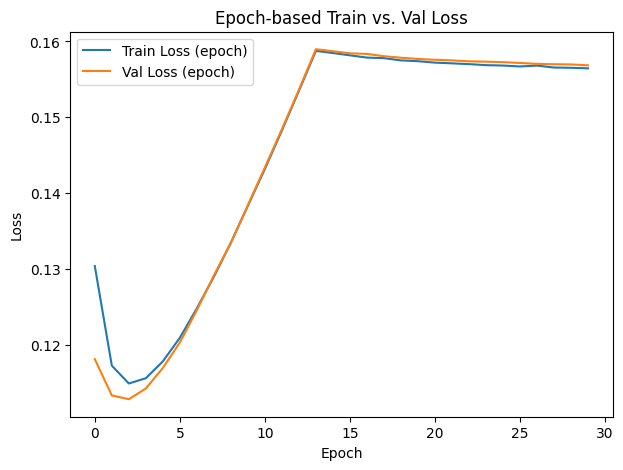

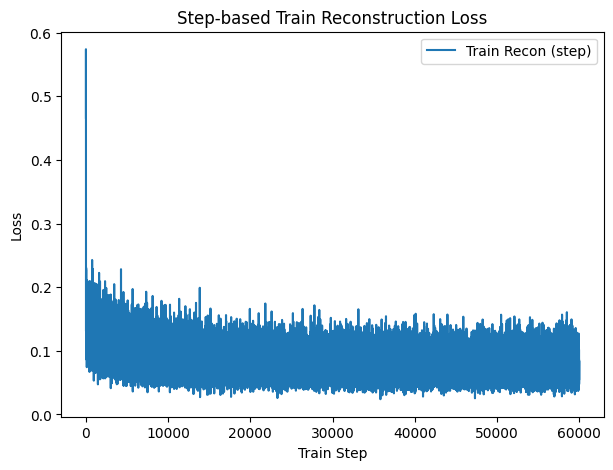

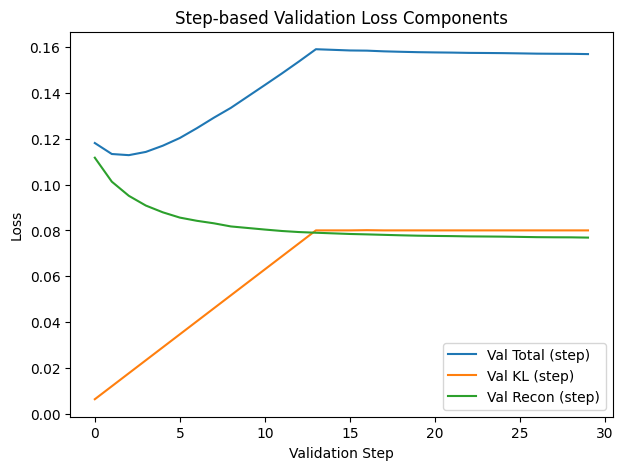

In [15]:
# Plot training and validation losses
plot_losses(all_losses)

In [16]:
# Track tensor changes in the model
track_tensor_values(vae, test_loader, device)

### Tensor Değerlerinin Takibi ###
Giriş Görüntüsü: Min: -1.0151960849761963, Max: 1.4063724279403687, Mean: 0.13055969774723053
Encoder Block 1 Çıkışı: Min: -4.484758377075195, Max: 4.3262481689453125, Mean: 0.07254976779222488
Encoder Block 2 Çıkışı: Min: -8.608307838439941, Max: 14.385899543762207, Mean: 0.17087963223457336
Latent Uzay: Min: -4.5449676513671875, Max: 11.103614807128906, Mean: 0.14051443338394165
Decoder Block 1 Çıkışı: Min: -40.93553161621094, Max: 20.143352508544922, Mean: 0.055488042533397675
Decoder Block 2 Çıkışı: Min: -164.87709045410156, Max: 160.83328247070312, Mean: 0.0713018849492073
Decoder Çıkışı: Min: -0.2714833617210388, Max: 1.0, Mean: 0.025207024067640305


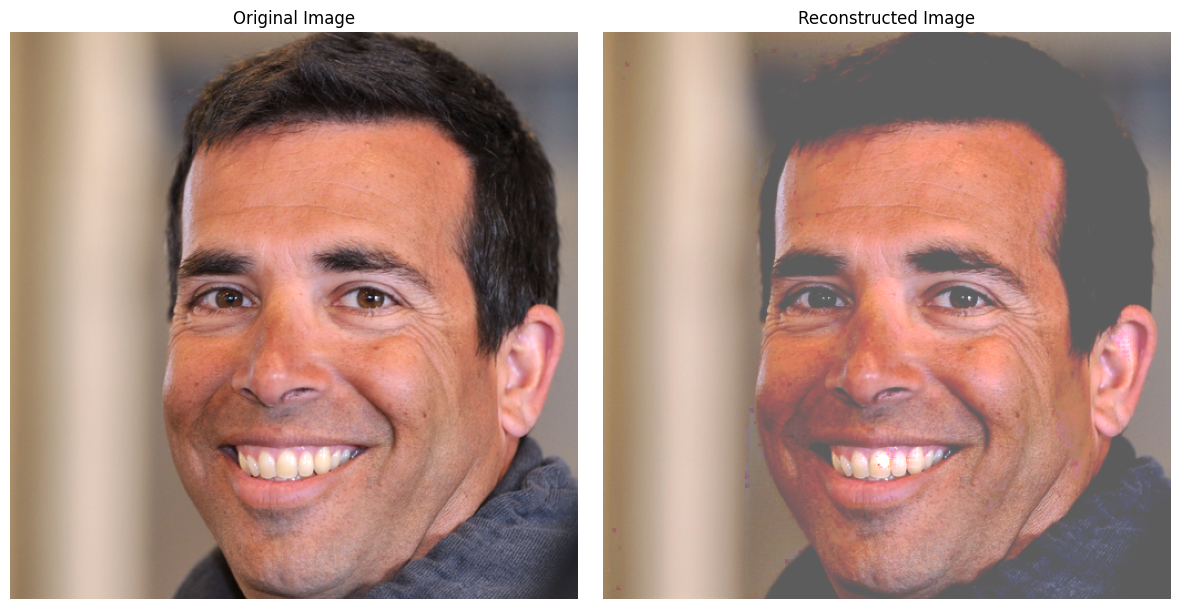

In [18]:
# Visualize input and reconstructed output images
visualize_random_input_output(vae, test_loader, device)